In [106]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42
sampler = Sampler()

import qautoencoder.qautoencoder as qae

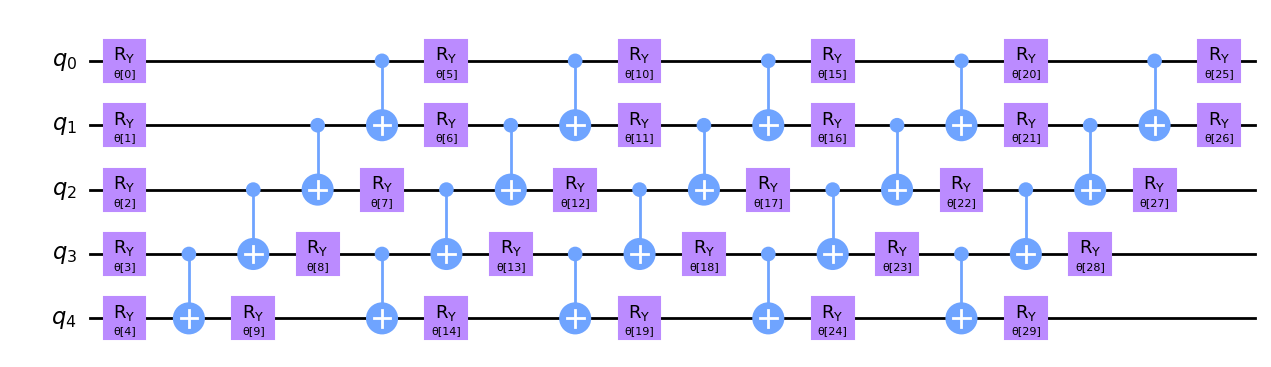

In [107]:

num_qubits = 5
circ = qae.ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")



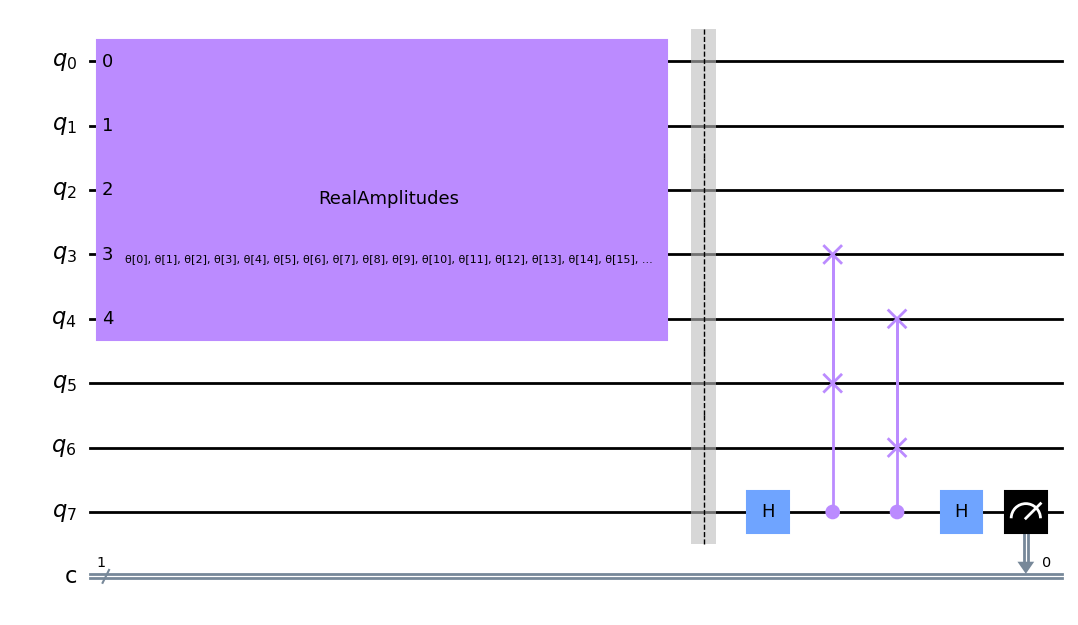

In [108]:
num_latent = 3
num_trash = 2
circuit = qae.auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

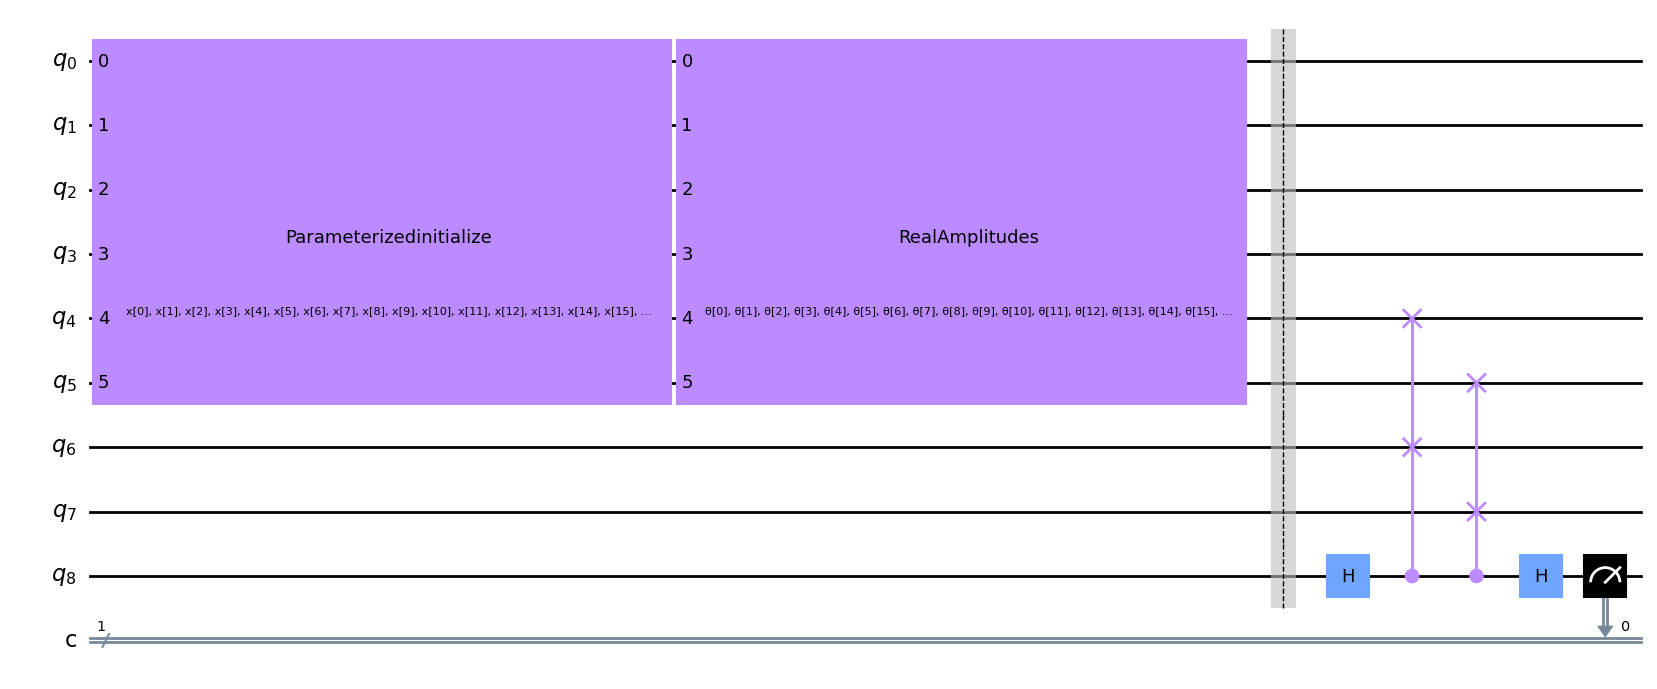

In [109]:
num_latent = 4
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = qae.auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="clifford")

In [110]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler,
)



No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


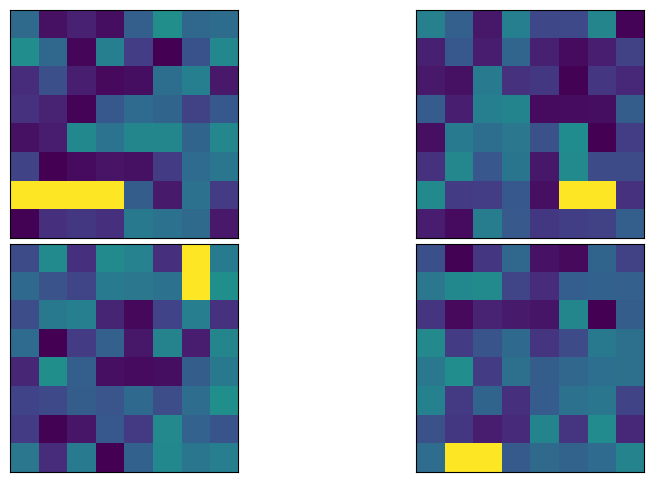

In [111]:
from qcnn.datasets import generate_line_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

width, height = 8, 8 # Change these variables
min_line_length, max_line_length = 2, 8 # Change these variables
display_rows = 2 # Change this variable

images, labels = generate_line_dataset(200, width=width, height=height, min_l=min_line_length, max_l=max_line_length)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

fig, ax = plt.subplots(display_rows, display_rows, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(display_rows * display_rows):
    ax[i // display_rows, i % display_rows].imshow(
        train_images[i].reshape(height, width),  # pixels length vector -> height x width view
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)
plt.show()

train_images = np.array(train_images)
train_images = train_images.reshape(len(train_images), width * height)

In [112]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

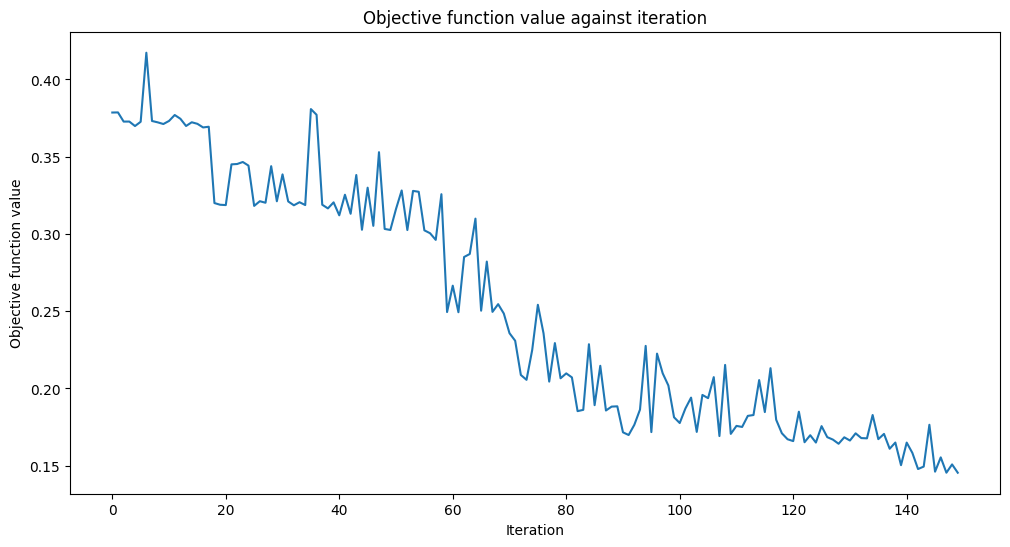

Fit in 221.90 seconds


In [113]:
opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=np.zeros(qnn.num_weights, dtype=float))
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

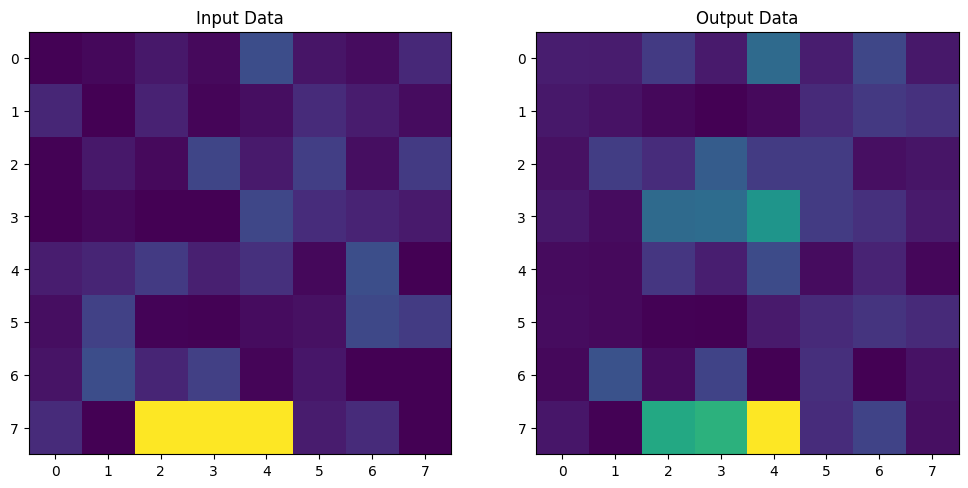

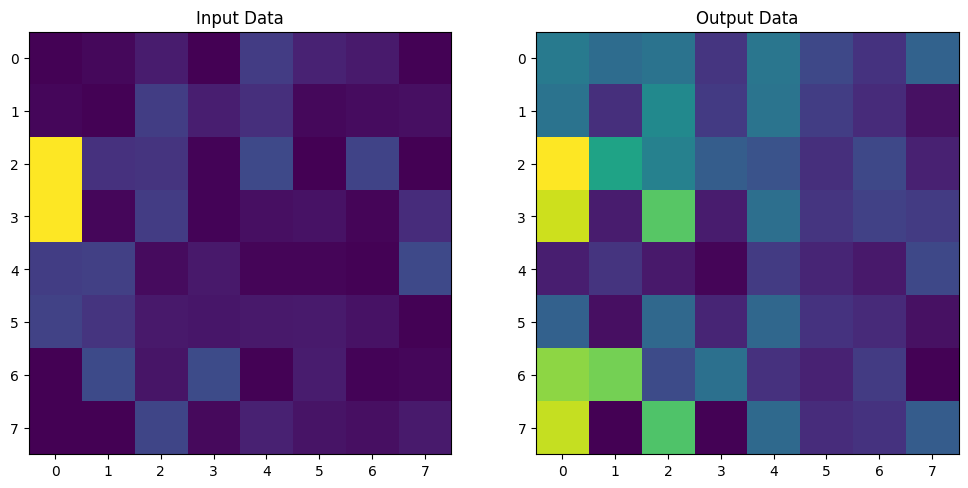

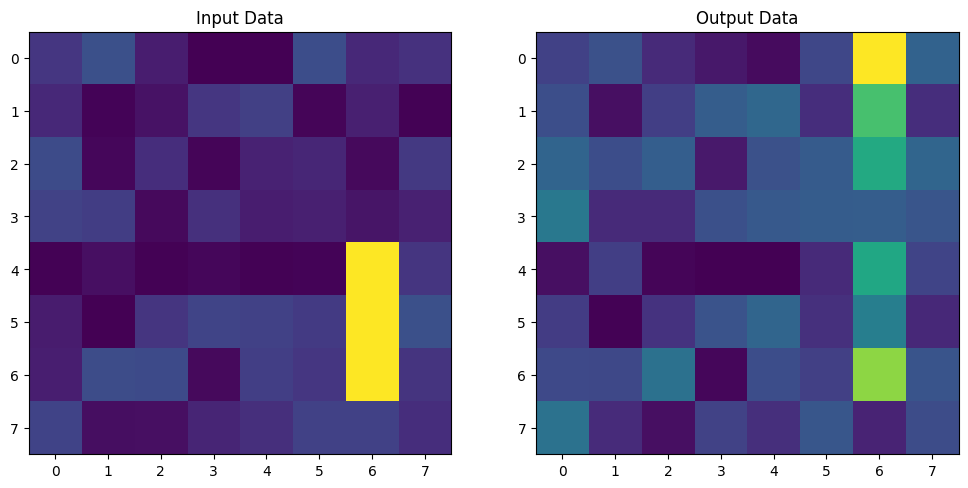

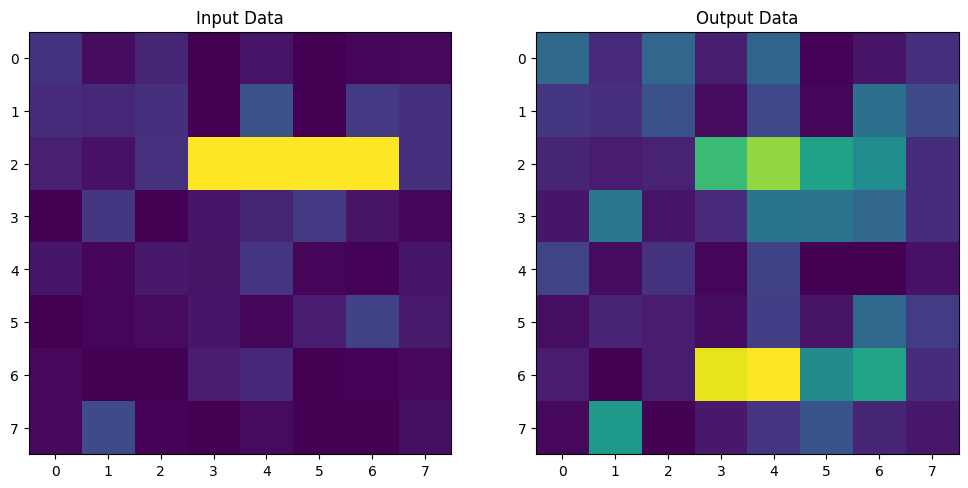

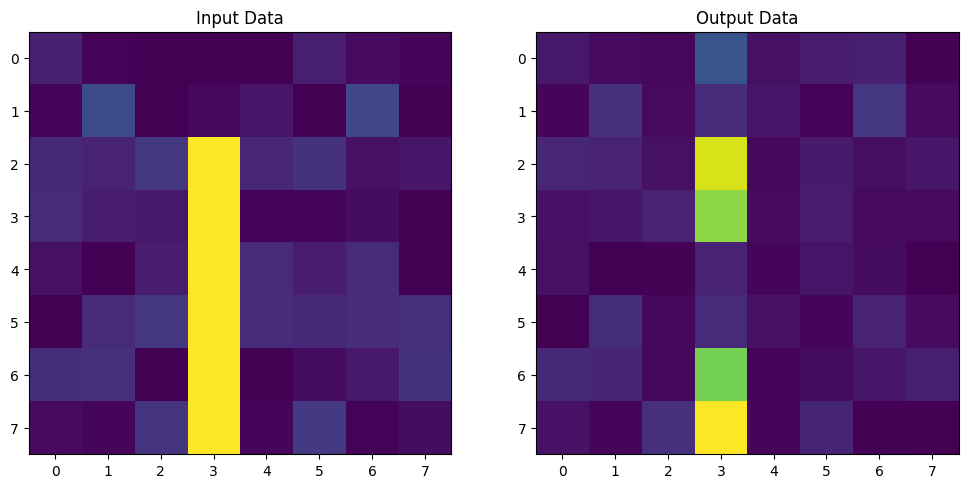

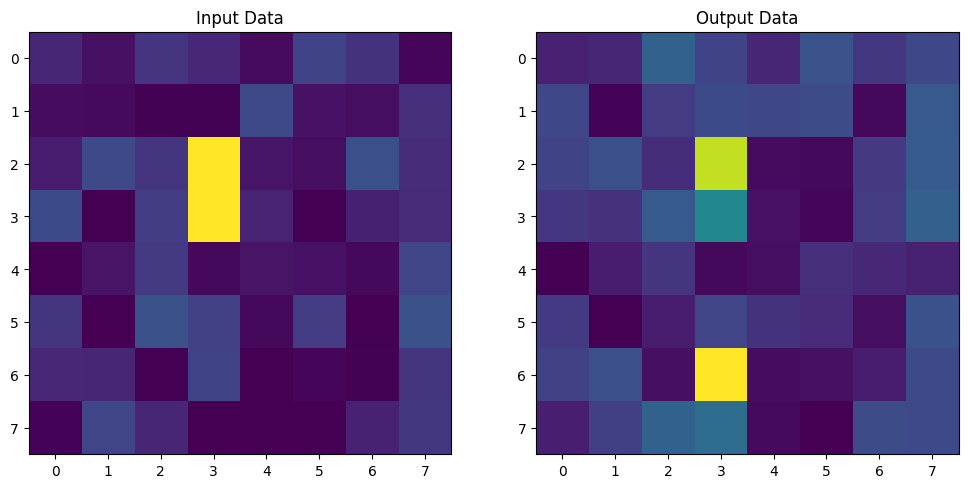

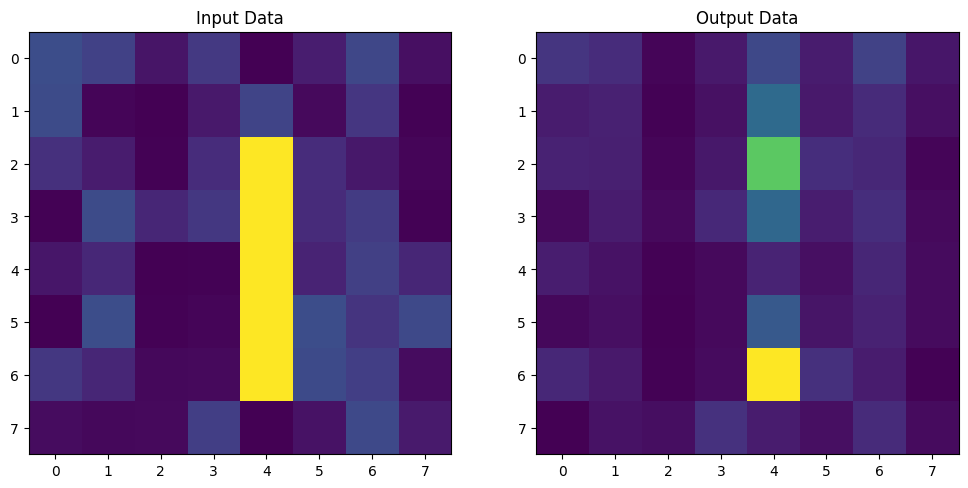

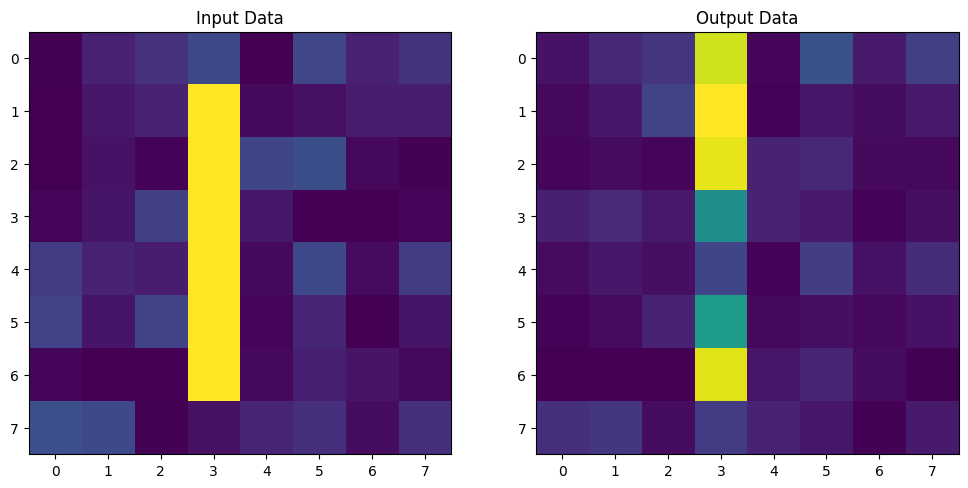

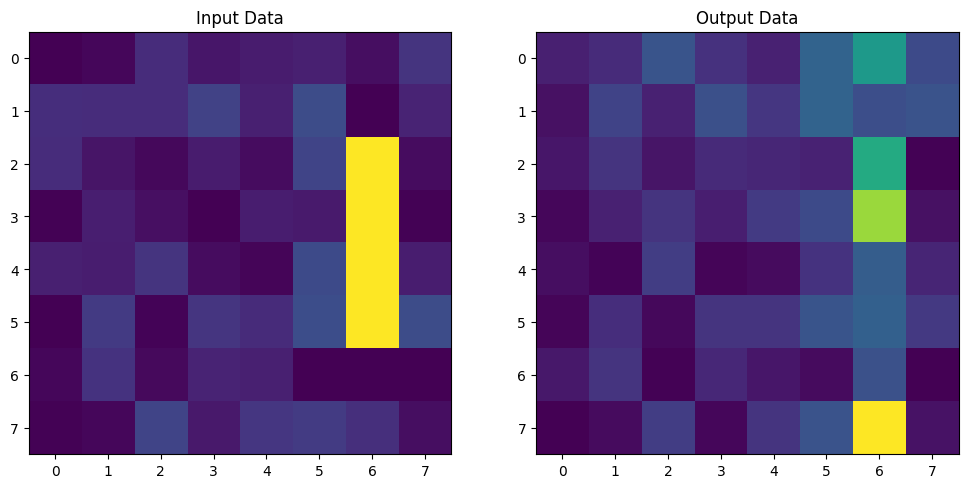

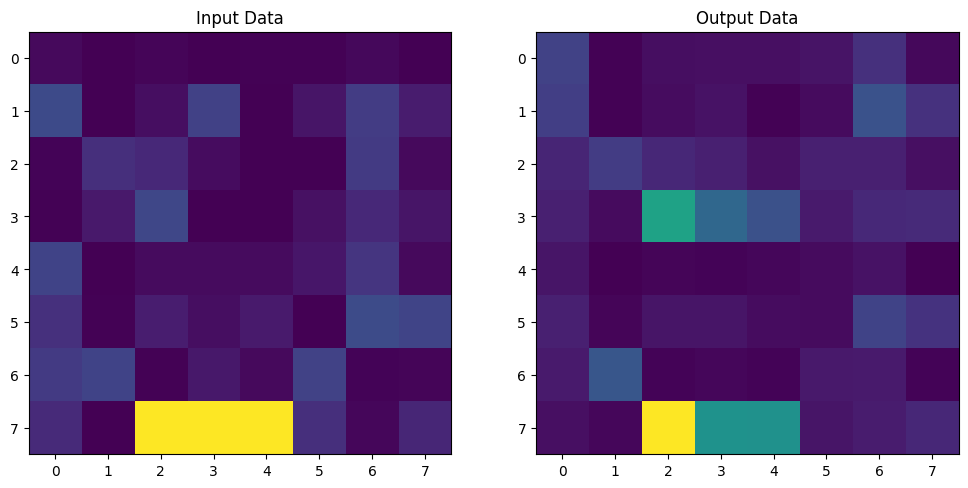

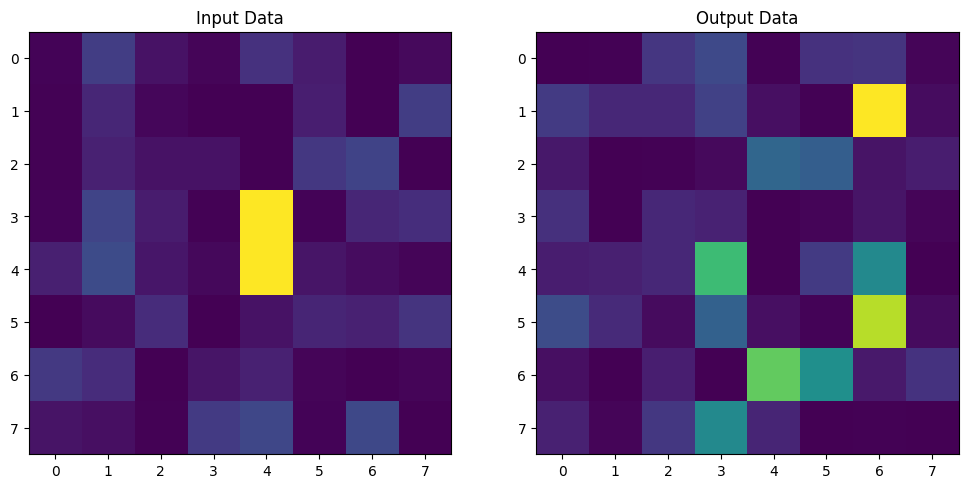

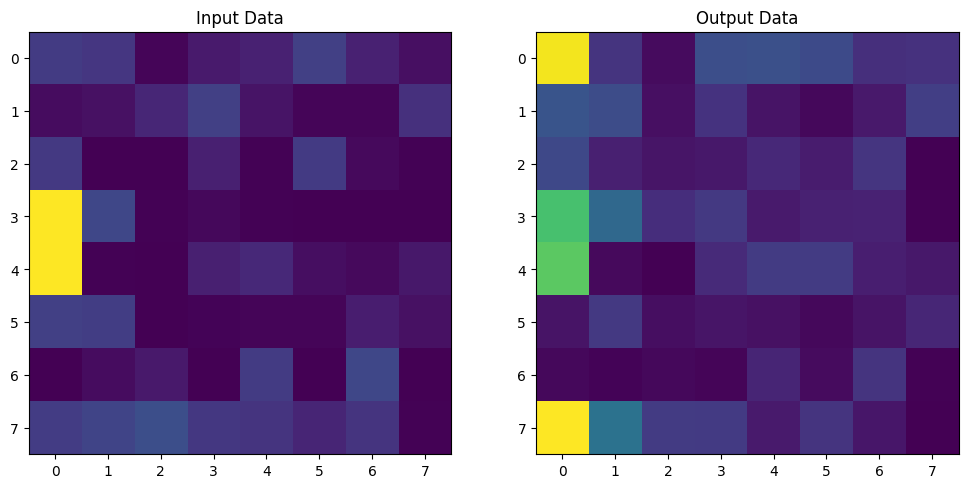

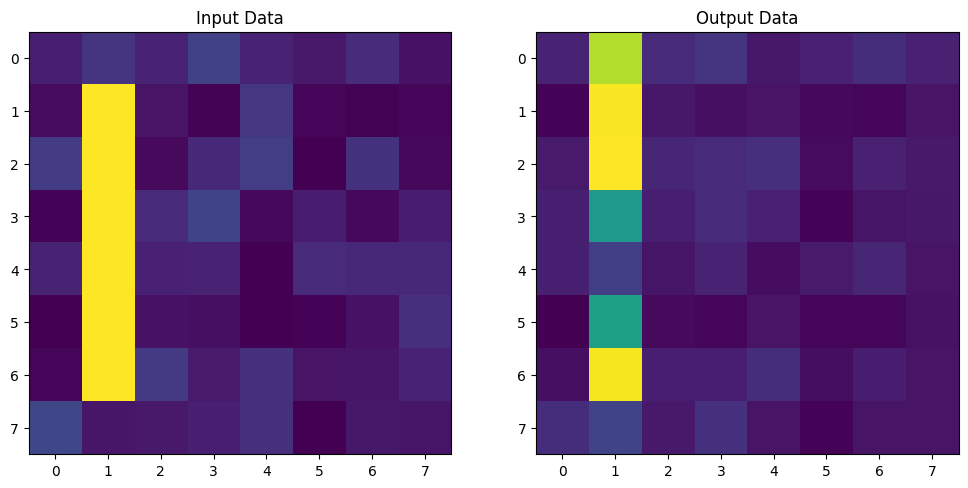

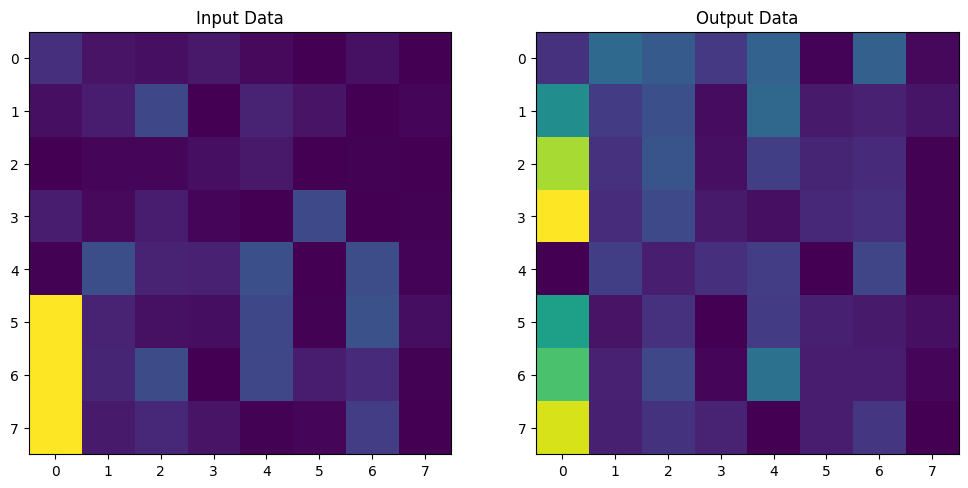

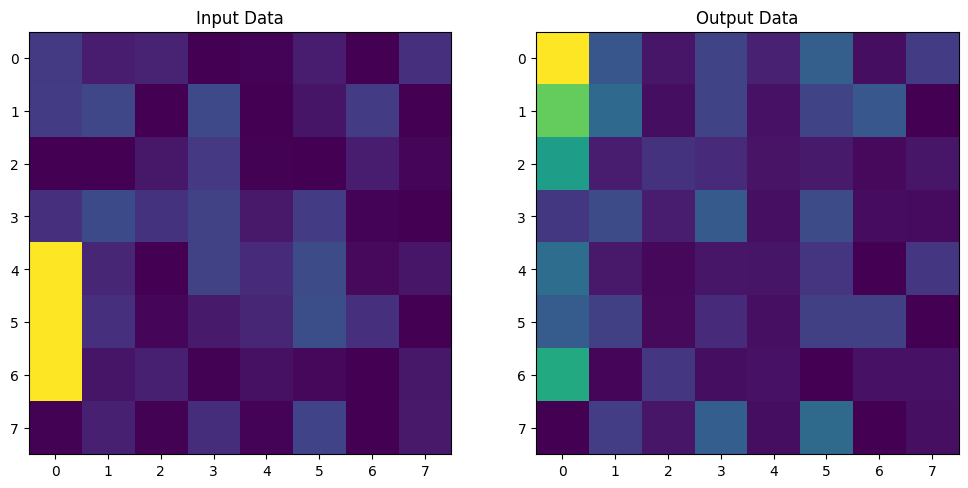

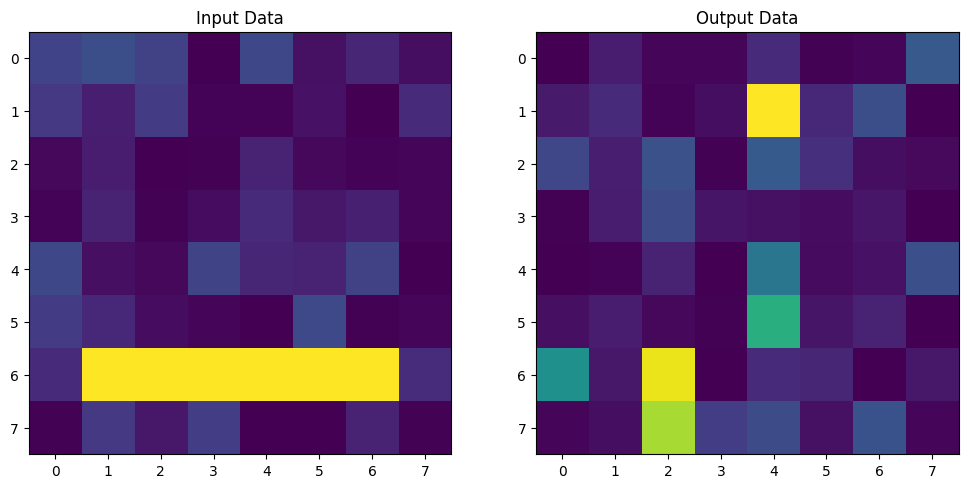

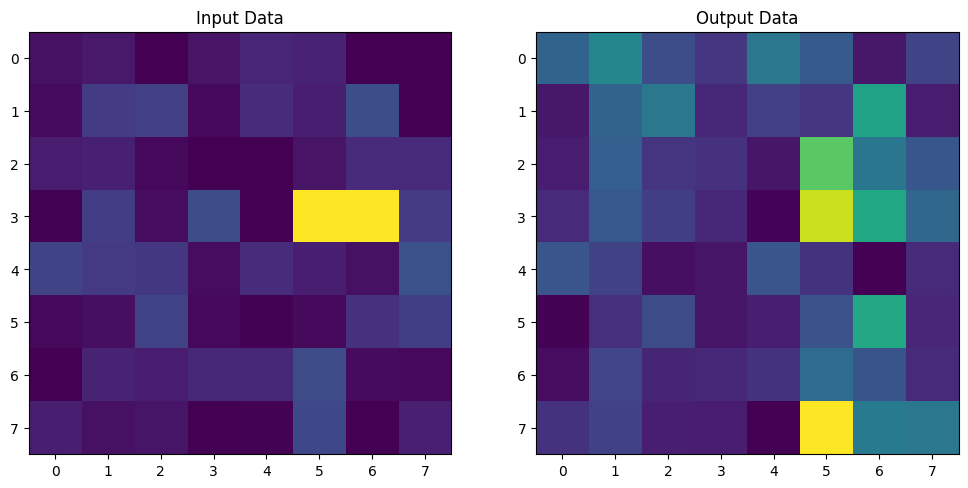

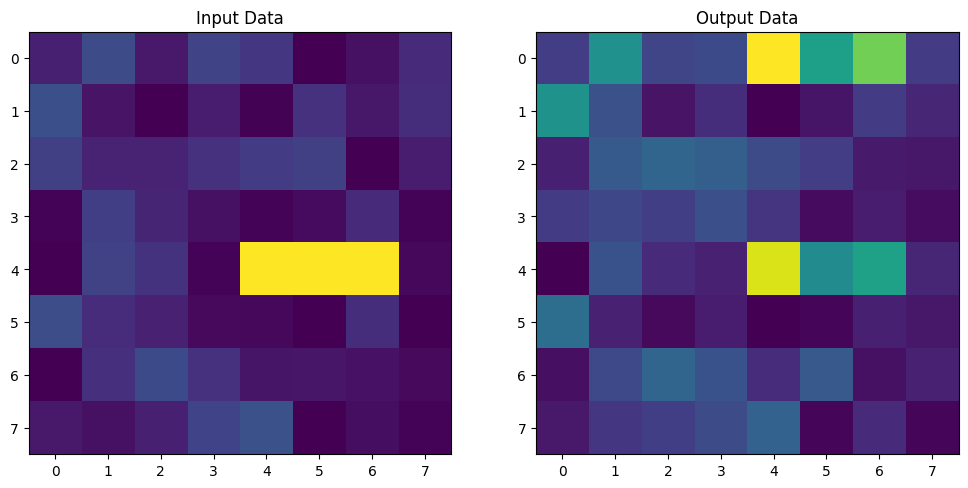

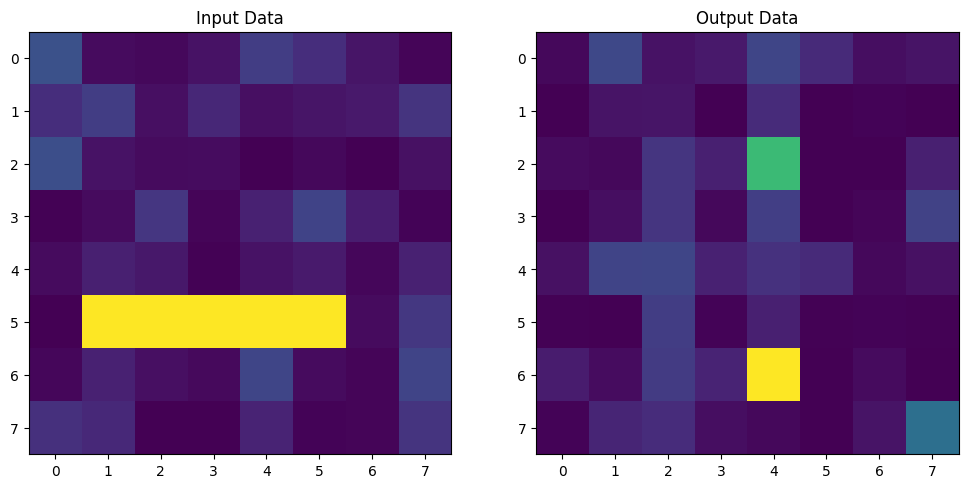

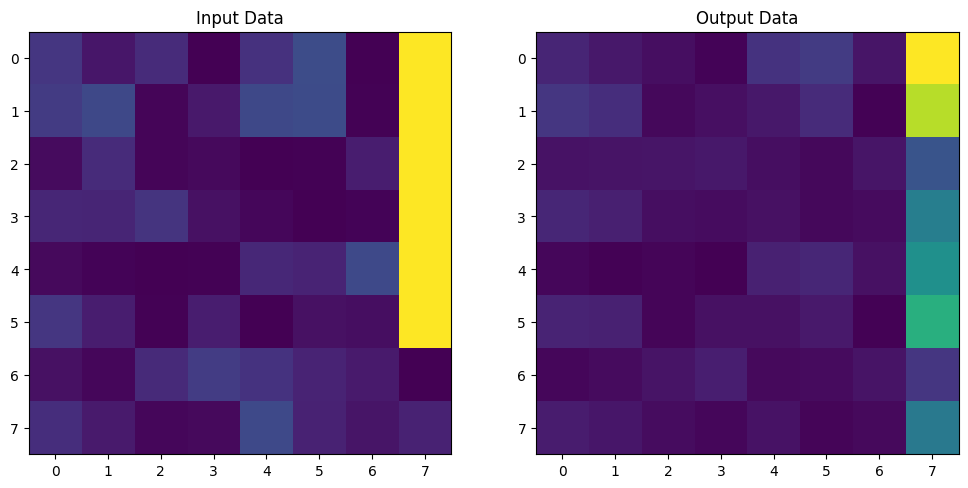

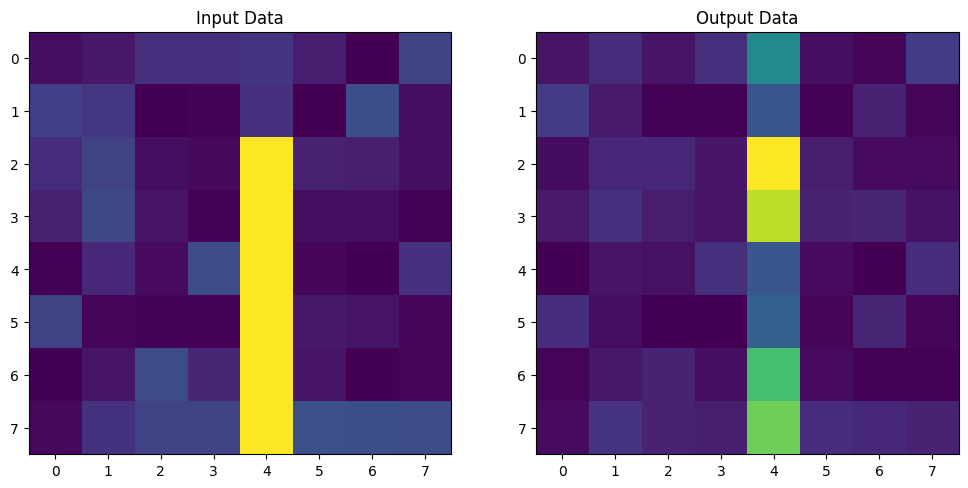

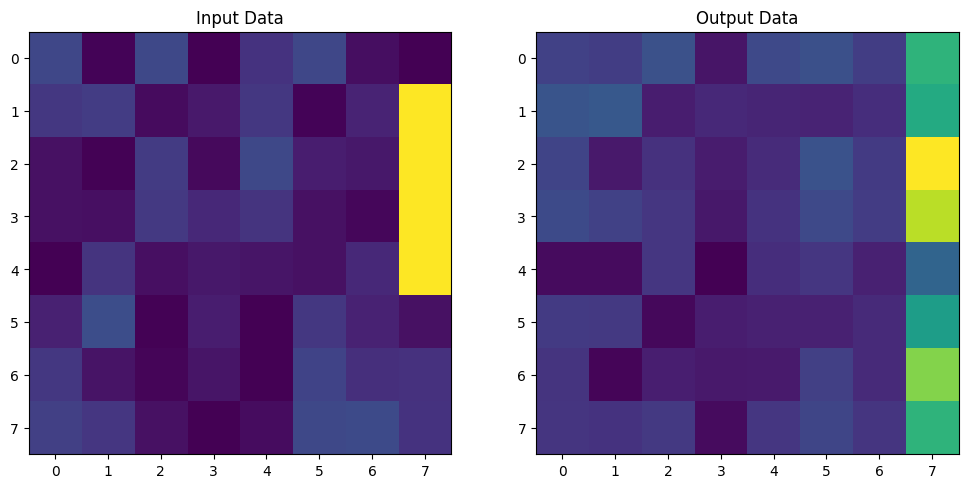

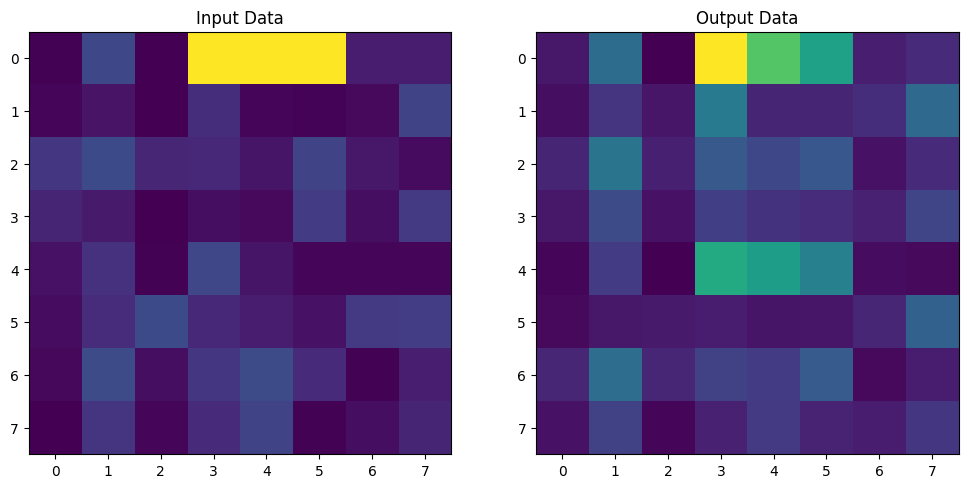

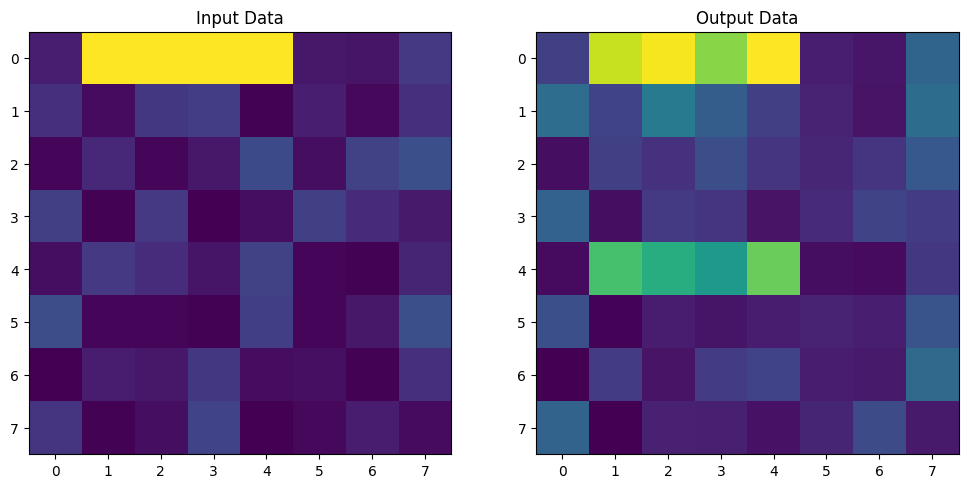

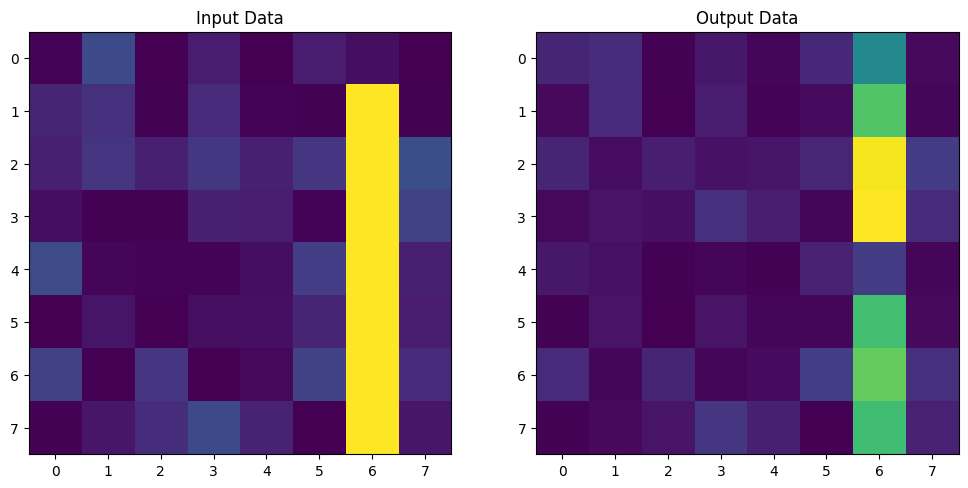

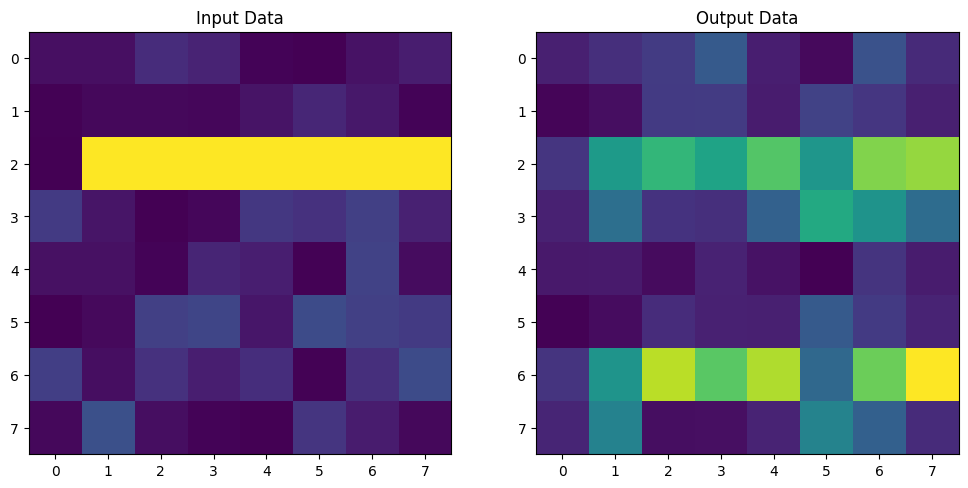

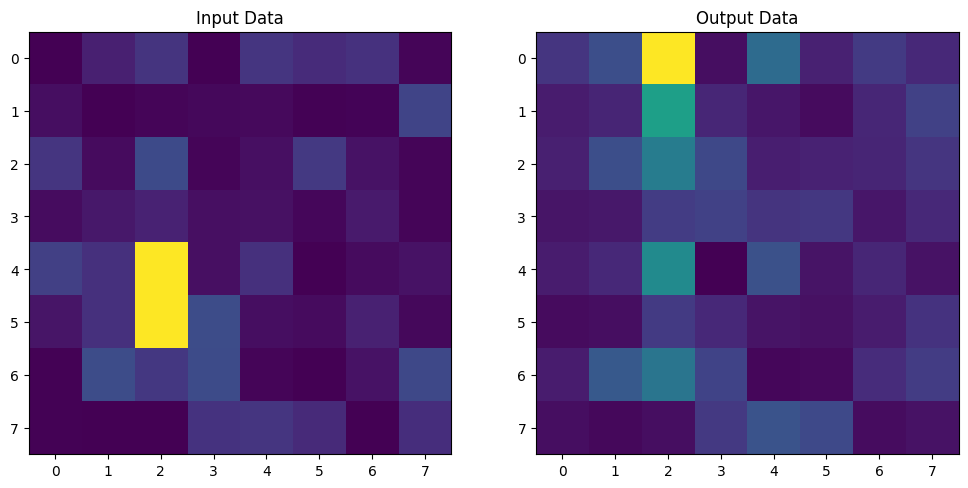

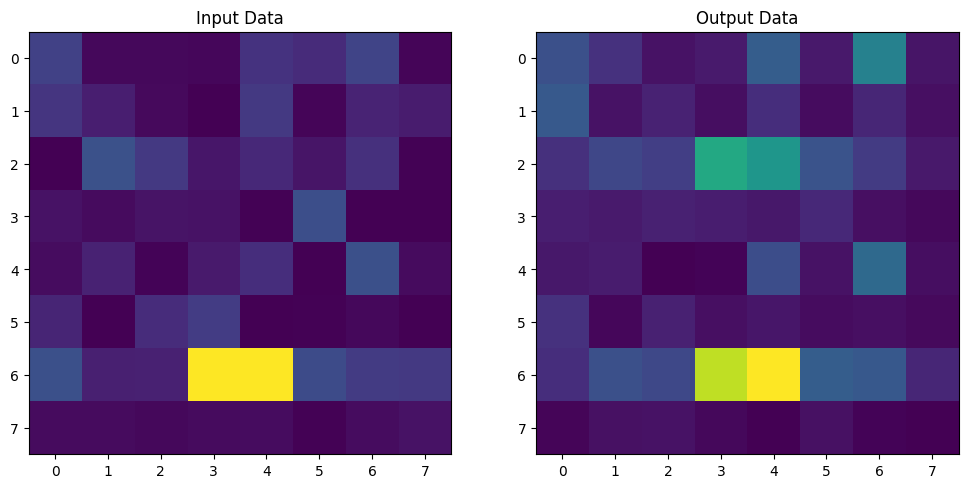

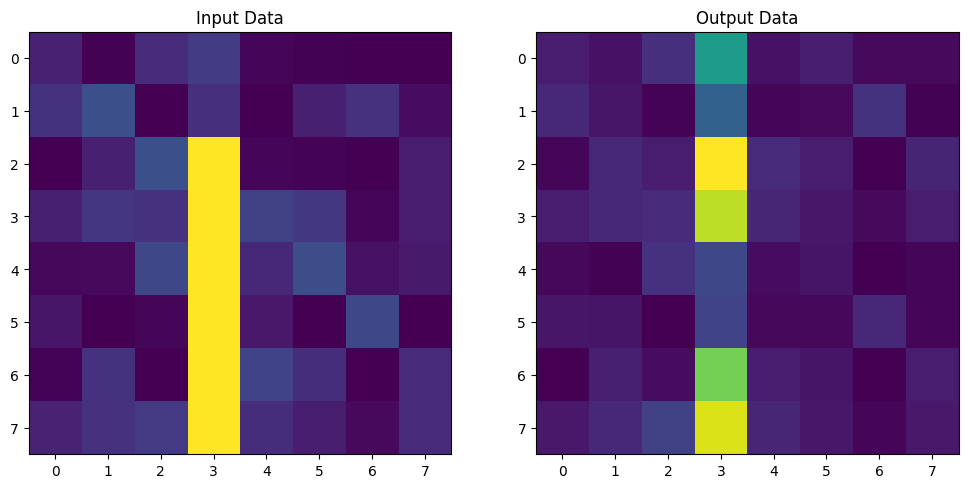

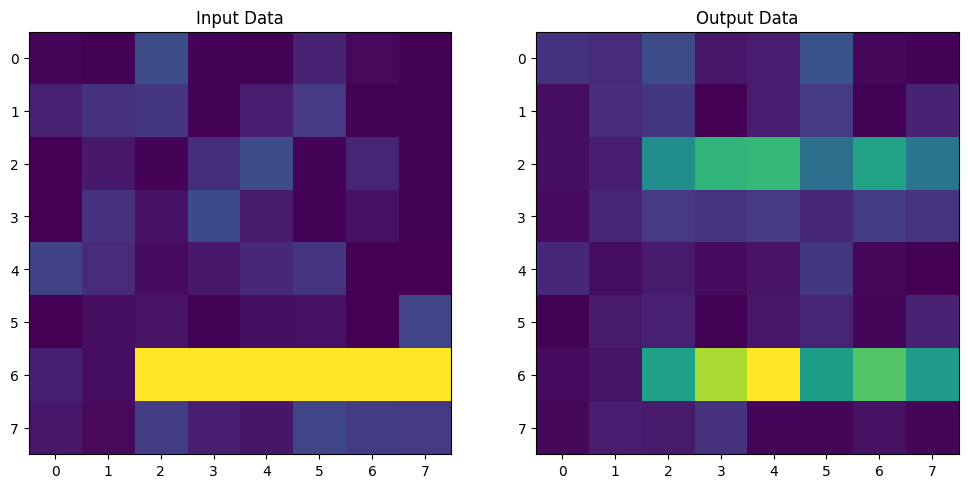

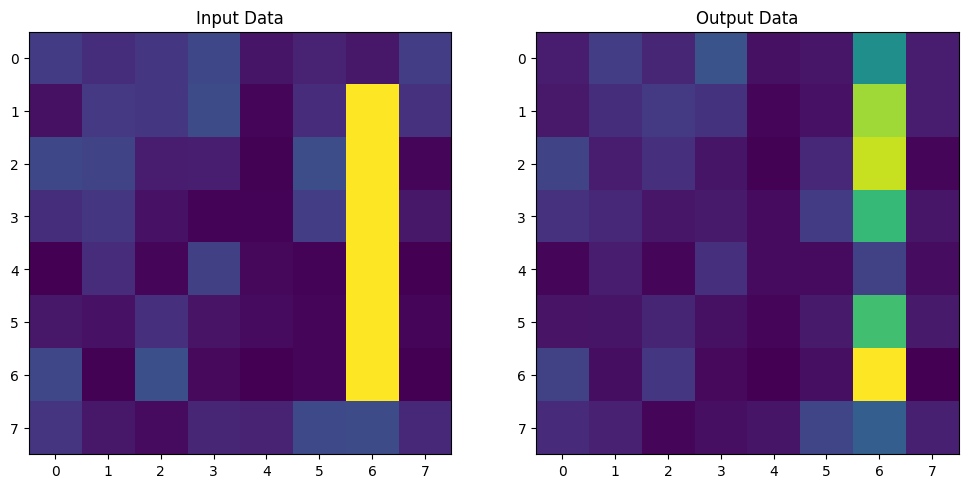

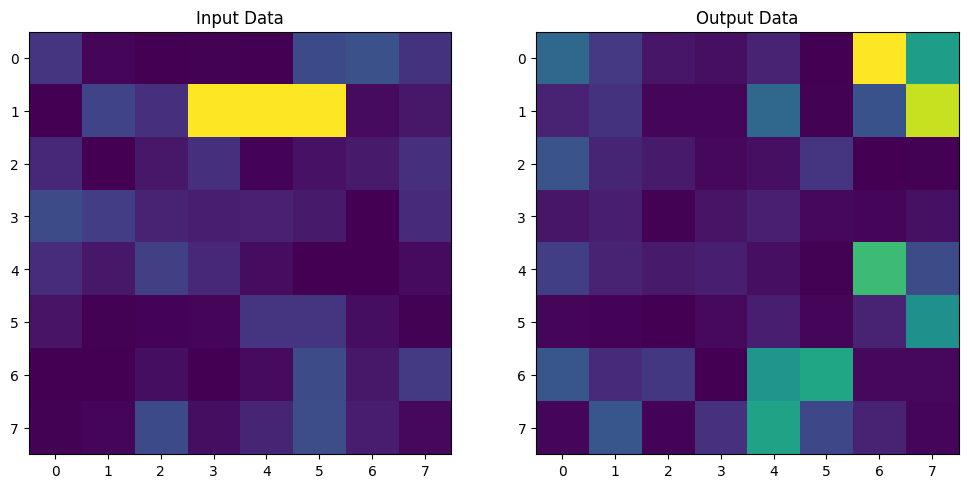

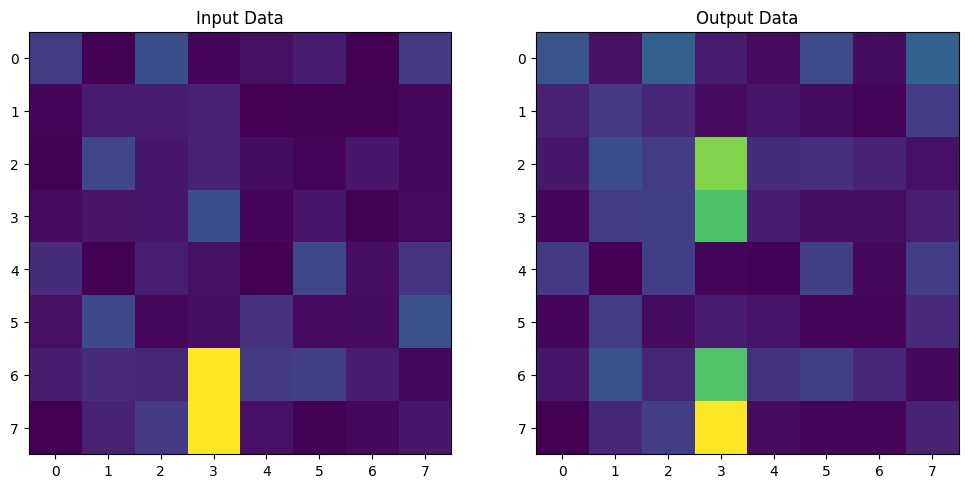

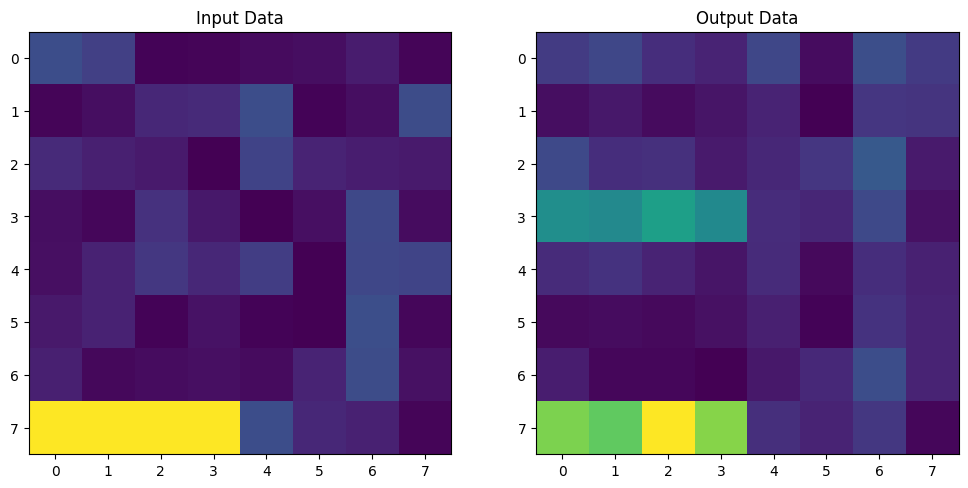

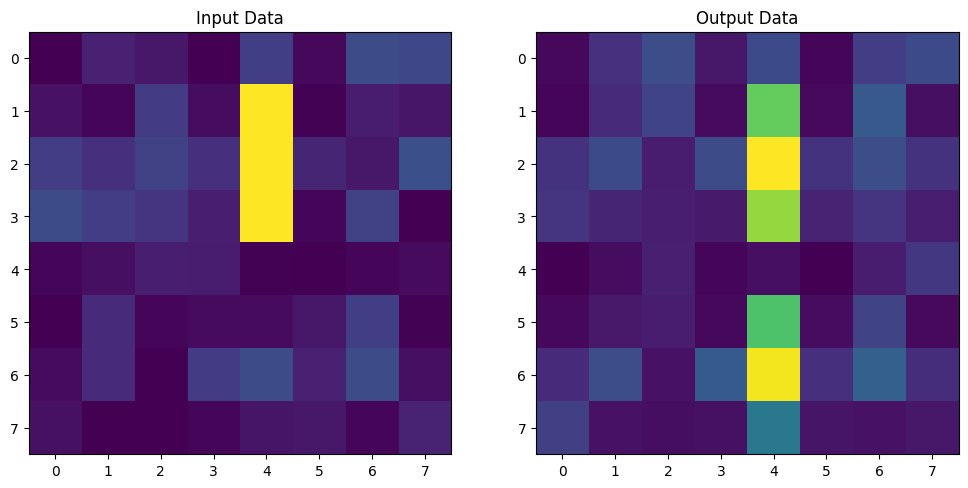

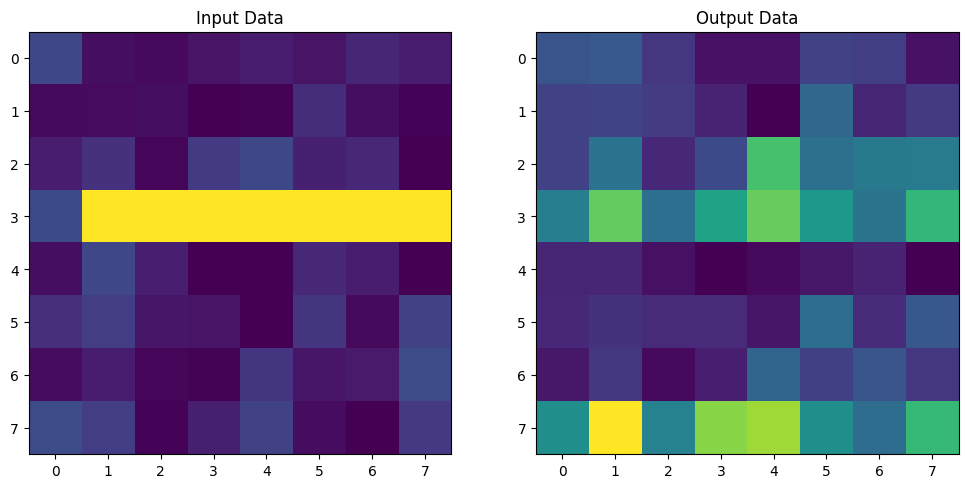

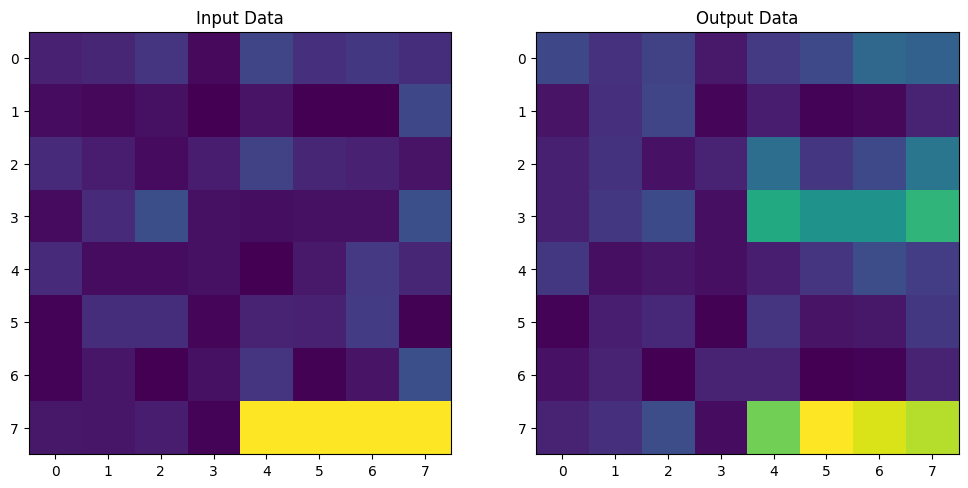

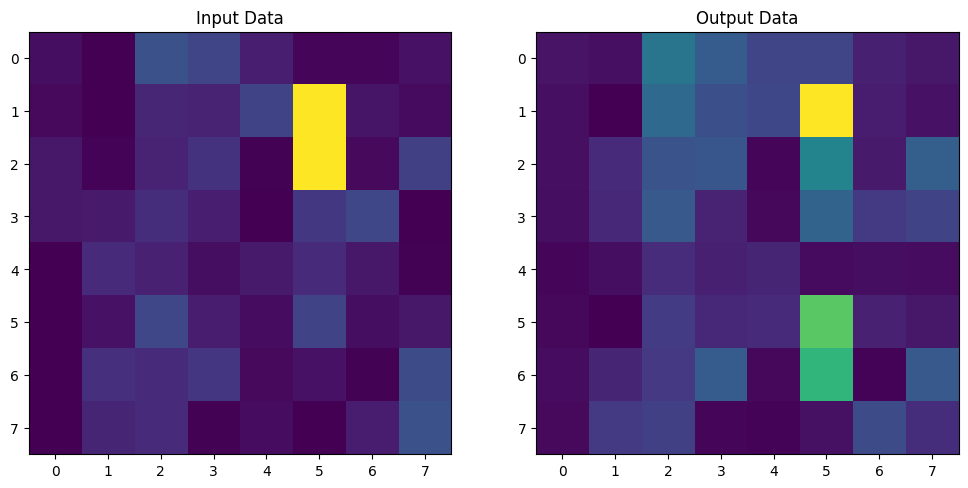

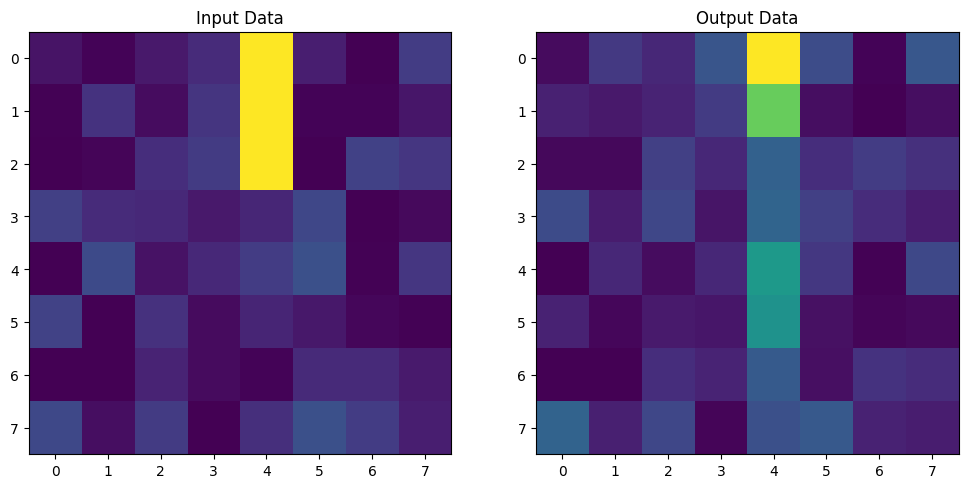

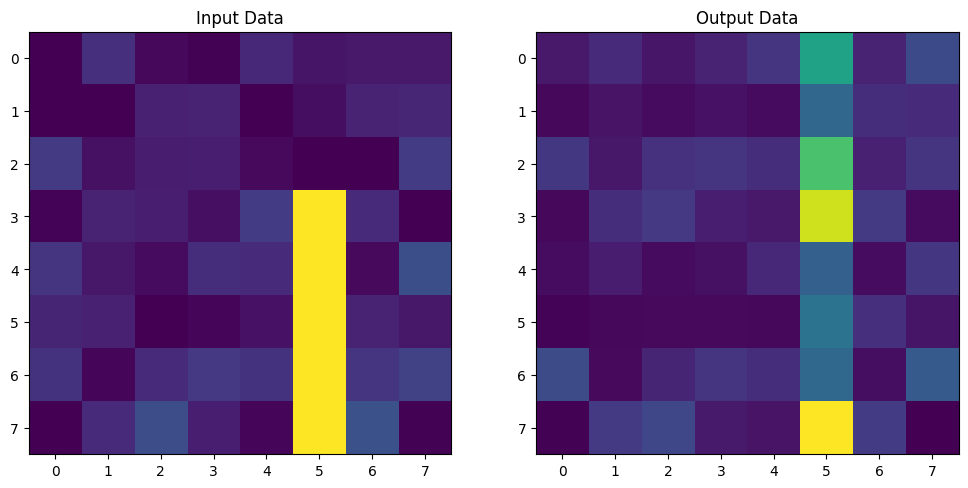

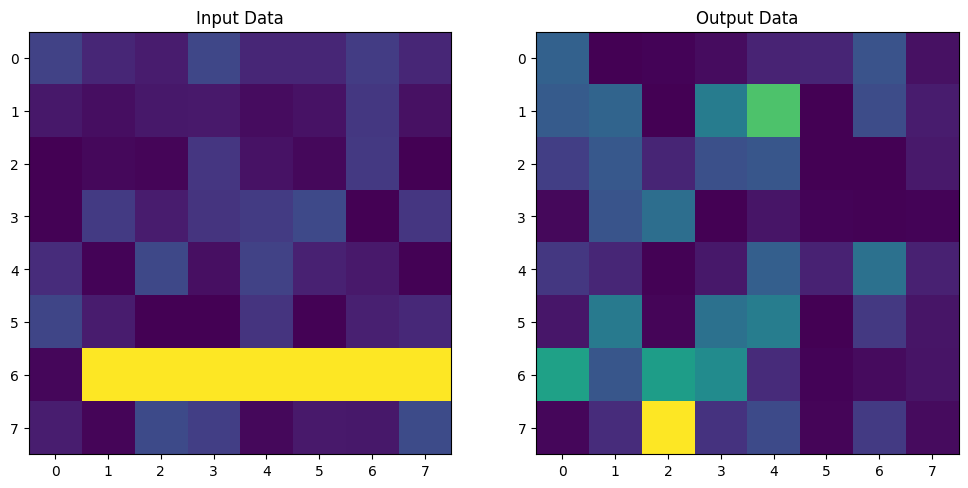

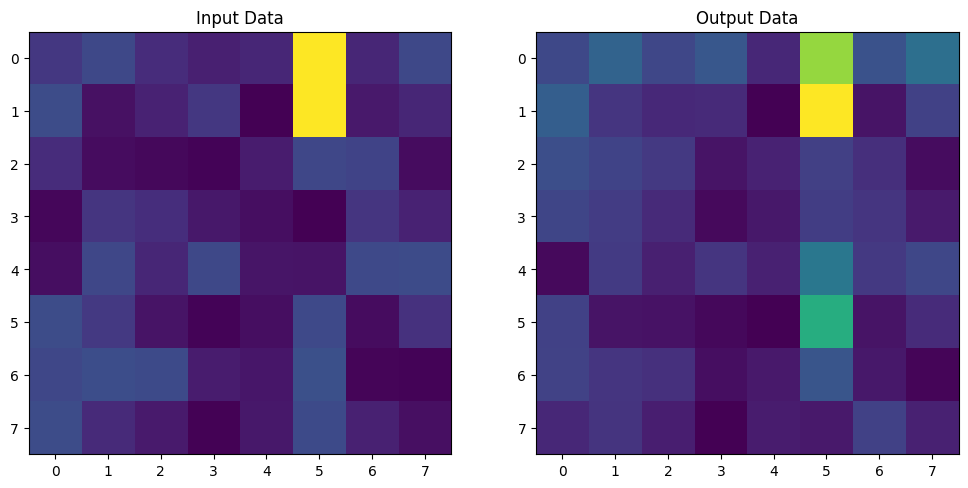

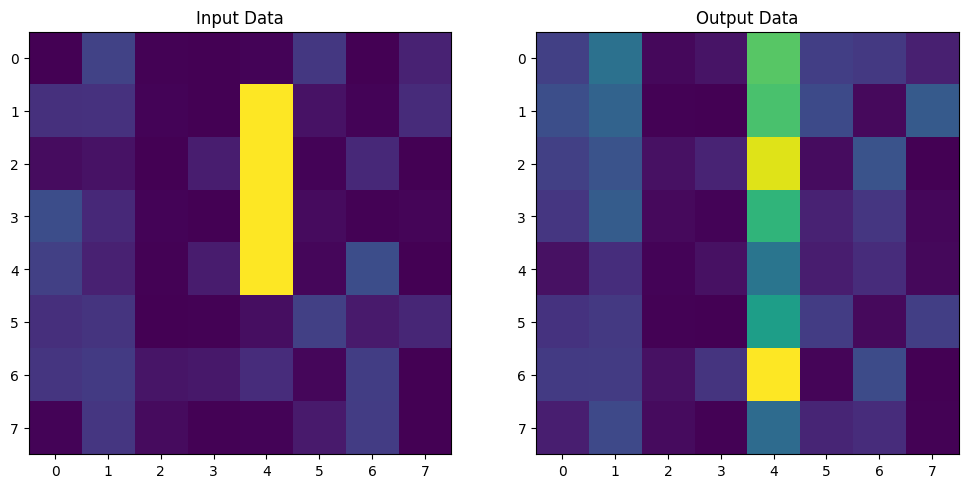

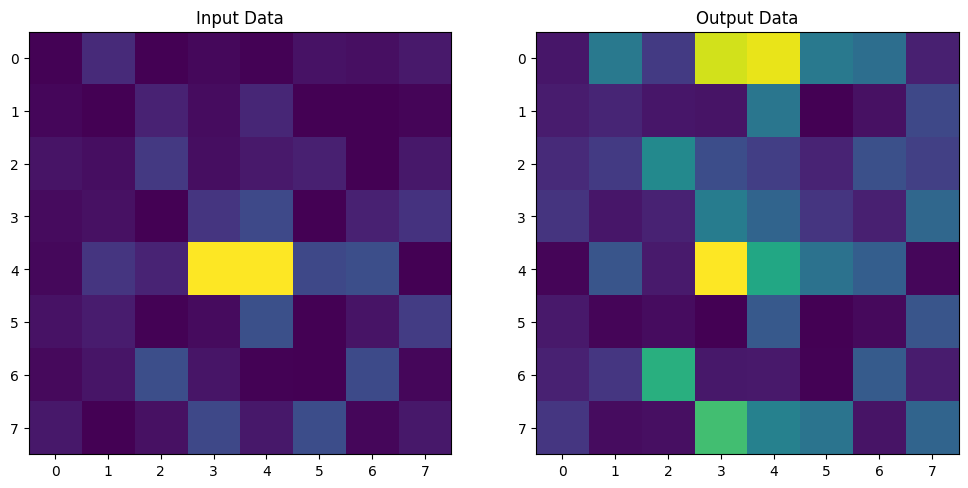

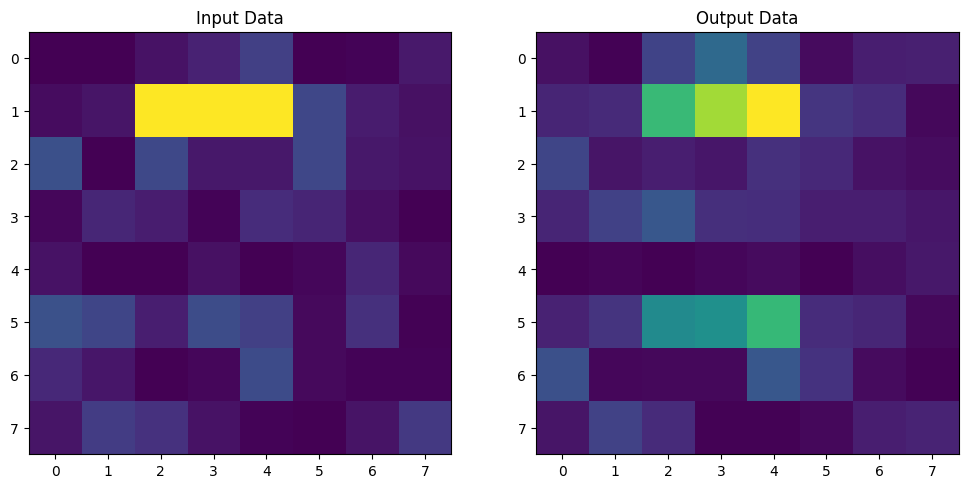

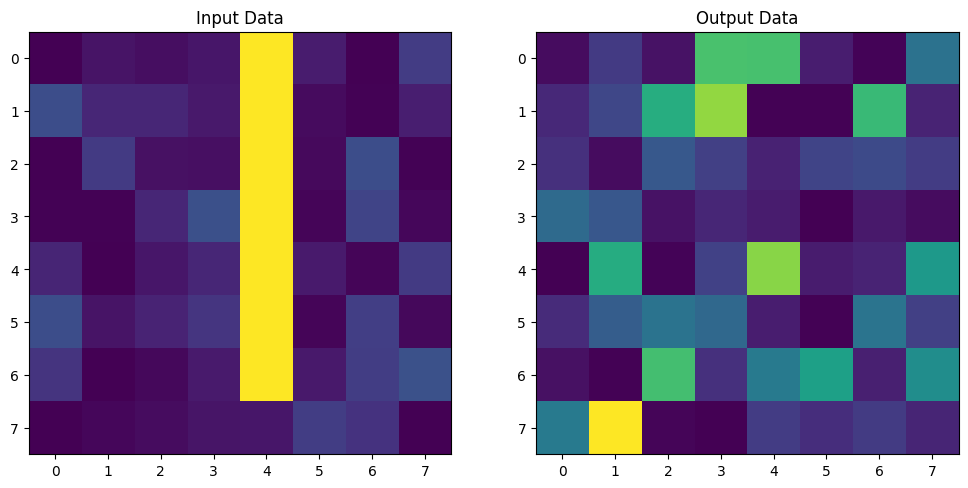

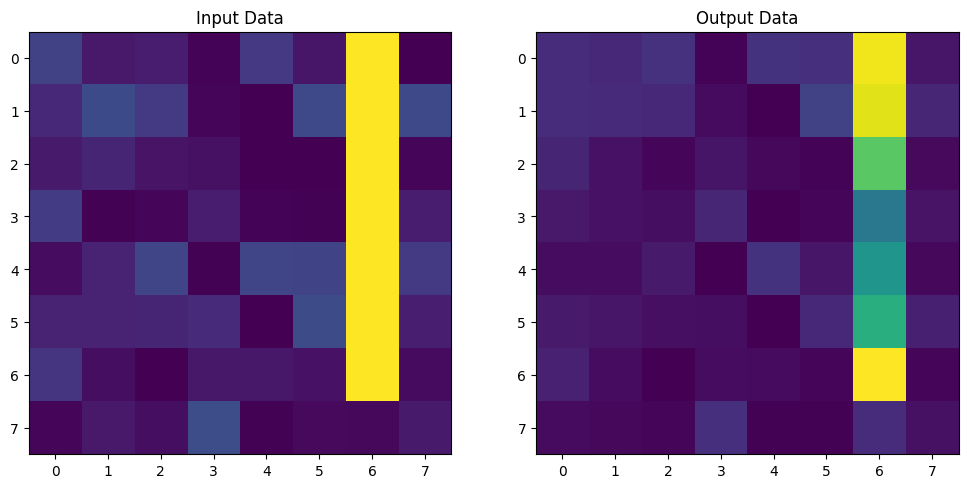

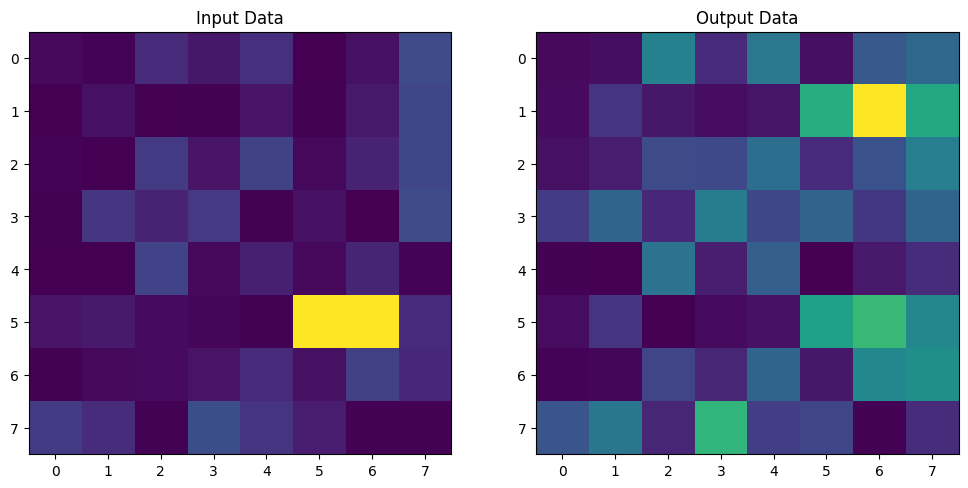

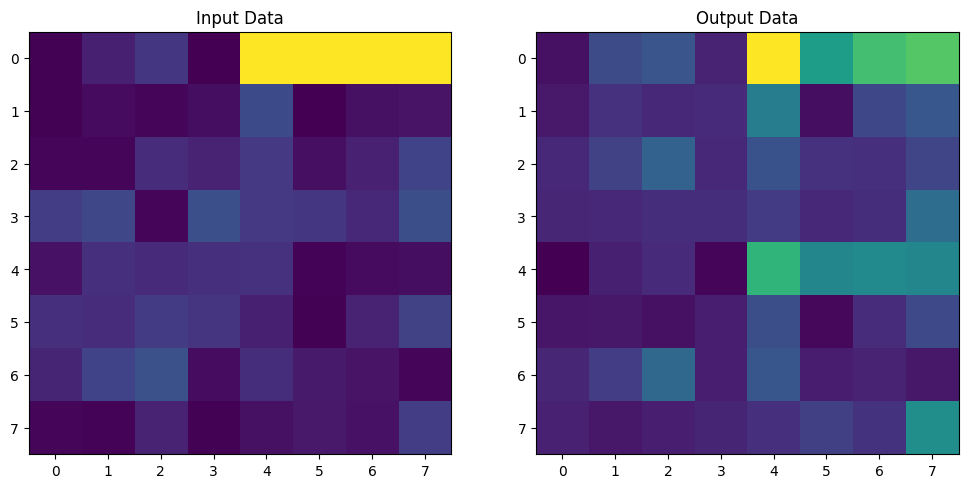

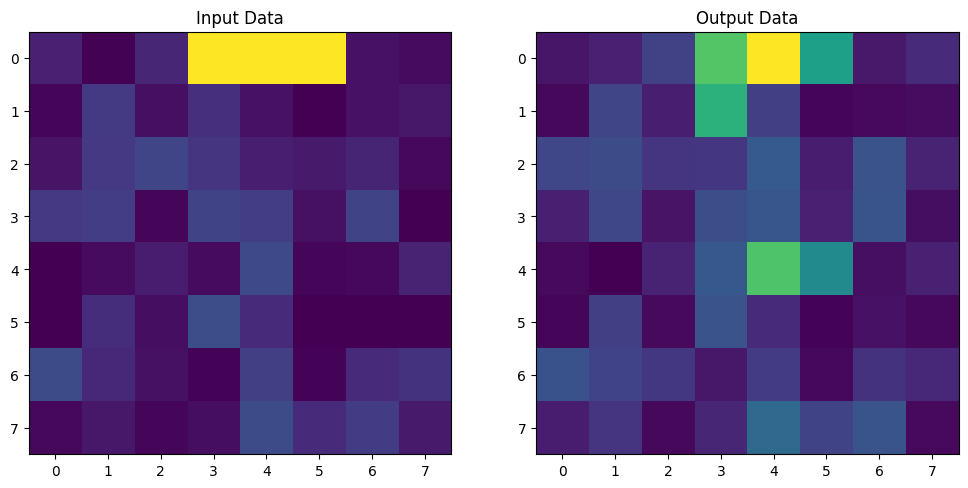

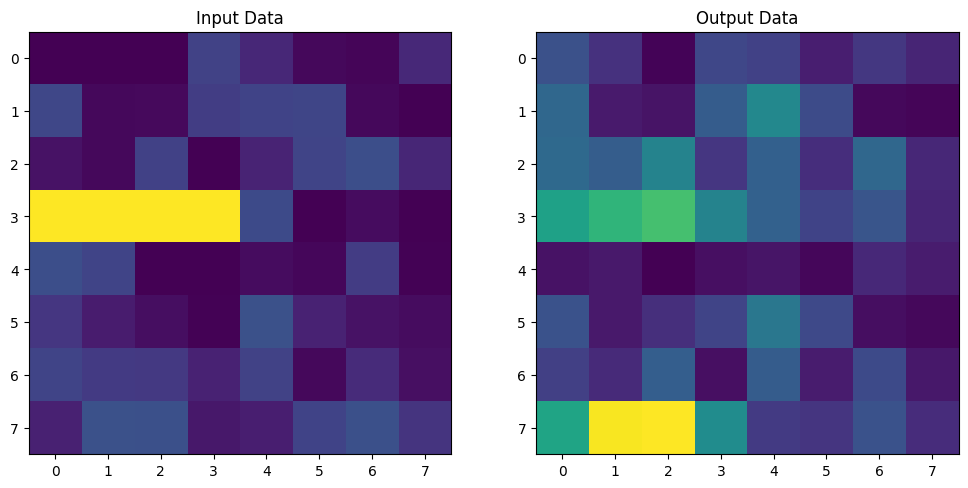

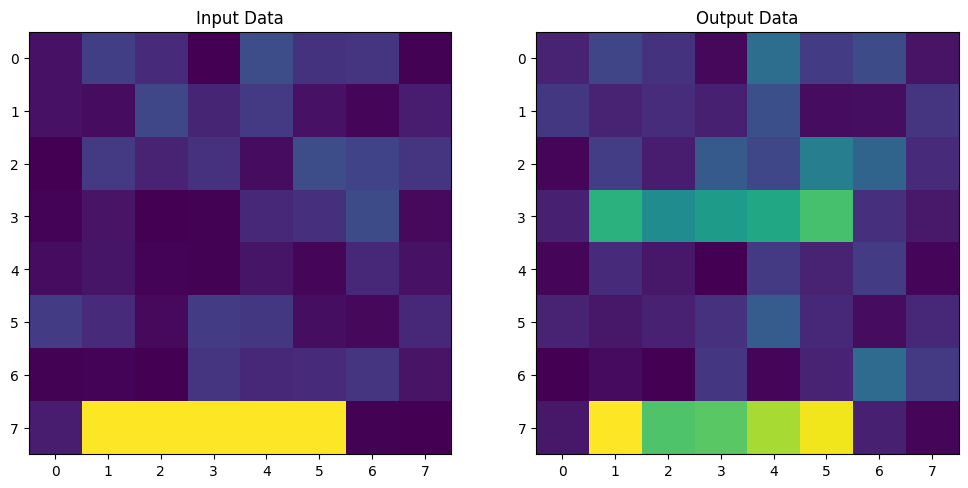

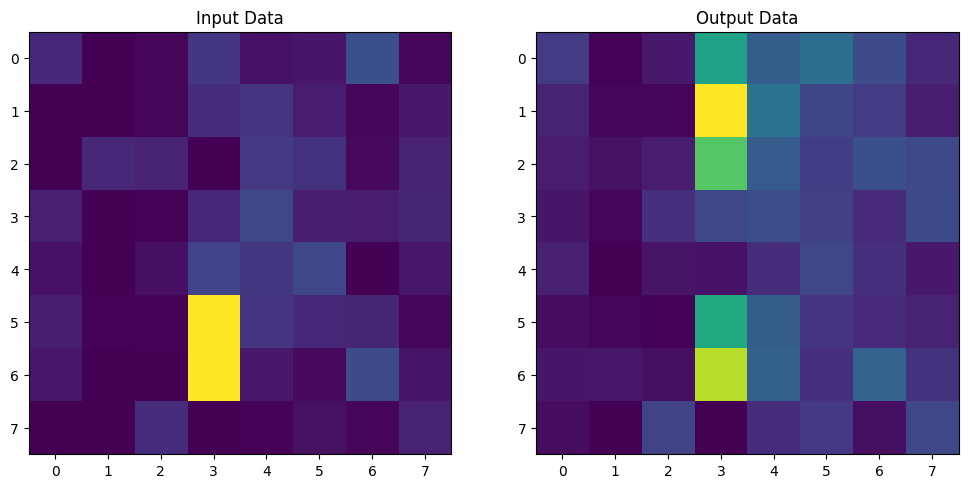

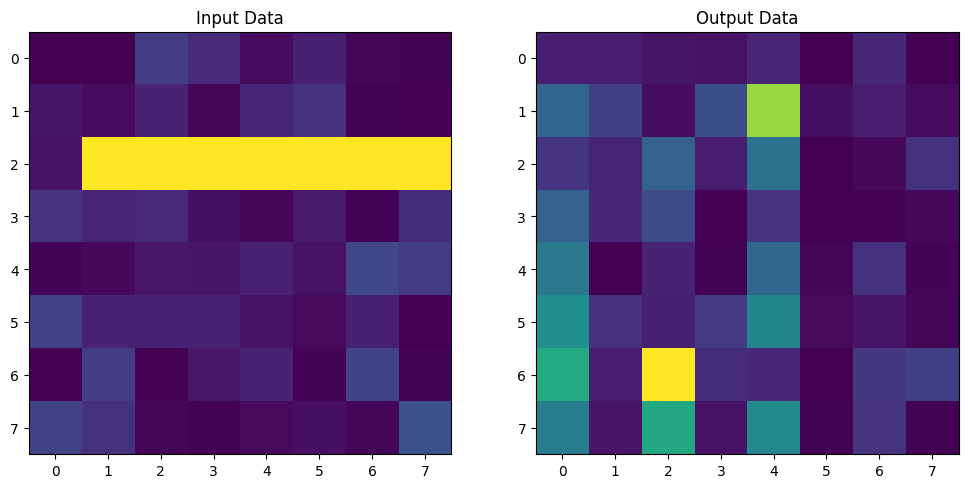

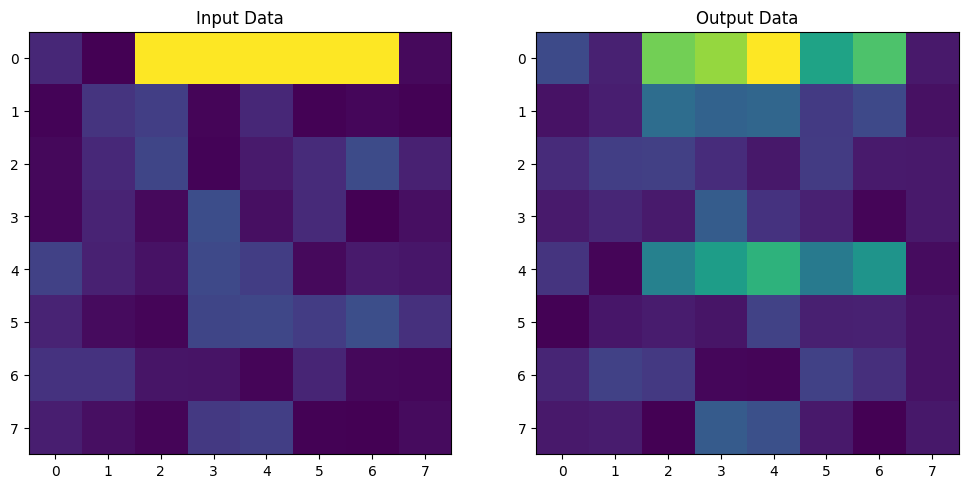

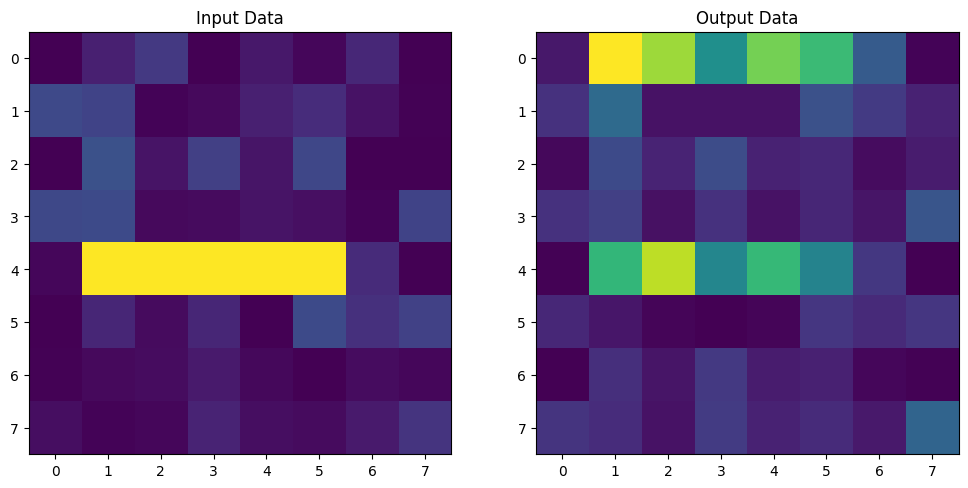

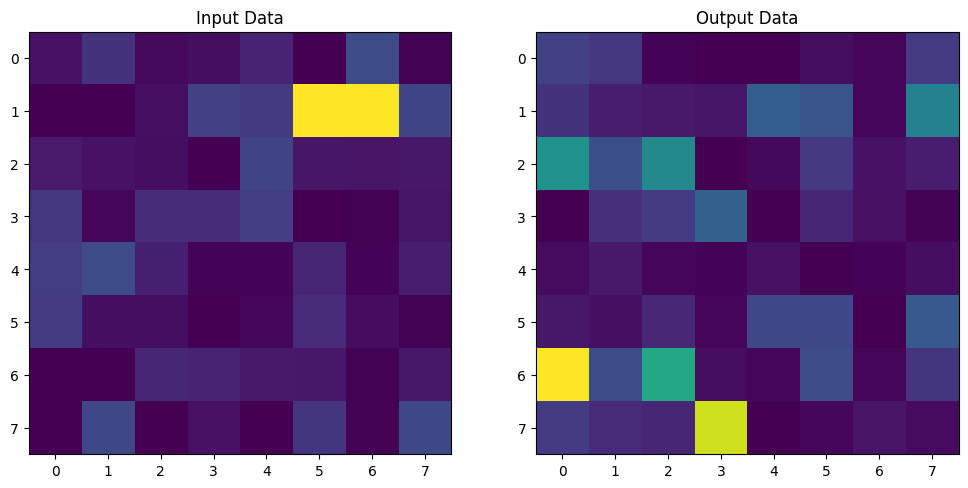

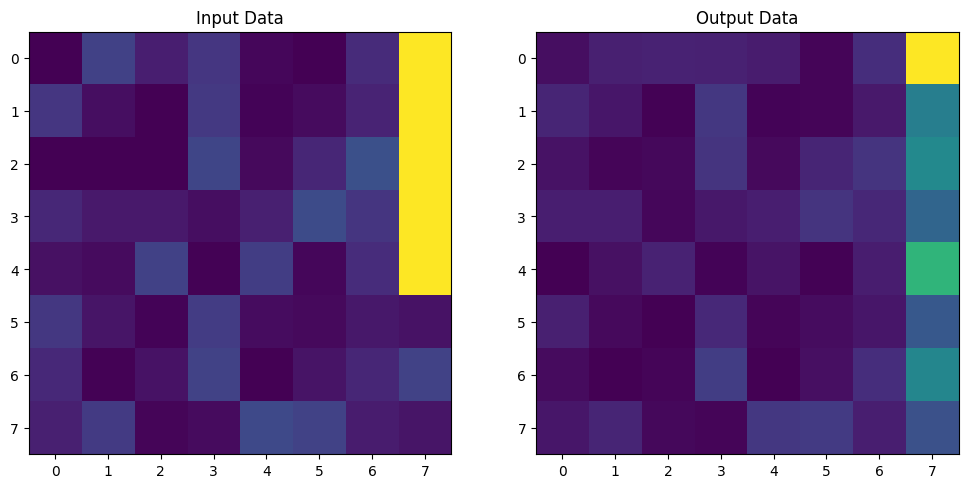

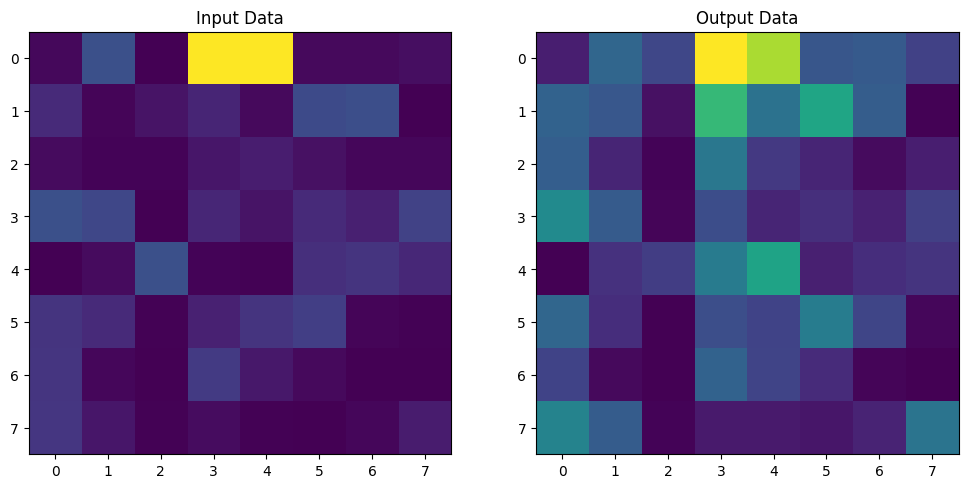

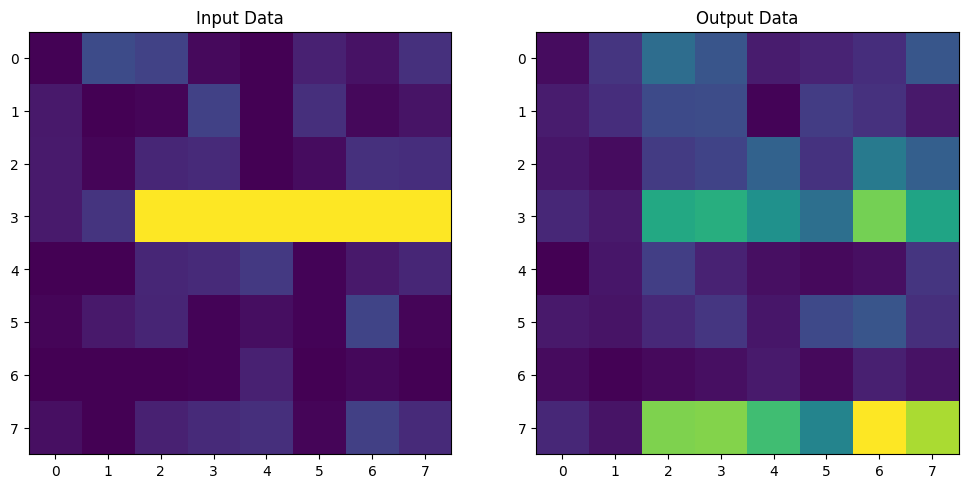

In [115]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = qae.ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()

for i in range(num_latent + 1, num_latent + num_trash):
    test_qc.reset(i)

test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (height, width))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (height, width))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

